Exercise 3
=========

In this exercise you should invetigate model order reduction by a modeal basis.
You should be able to re-use many parts from the previous exercises.

Consider the plate clamped at all edges.

In [1]:
from scipy.io import mmread
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import inv

import numpy as np

import matplotlib as matplot
import matplotlib.pyplot as plt
matplot.rcParams.update({'figure.max_open_warning': 0})

# Uncomment the following line and edit the path to ffmpeg if you want to write the video files!
#plt.rcParams['animation.ffmpeg_path'] ='N:\\Applications\\ffmpeg\\bin\\ffmpeg.exe'

from mpl_toolkits.mplot3d import Axes3D

import sys
np.set_printoptions(threshold=sys.maxsize)

from numpy.fft import rfft, rfftfreq

from utility_functions import Newmark

In [2]:
M = csc_matrix(mmread('Ms.mtx')) # mass matrix
K = csc_matrix(mmread('Ks.mtx')) # stiffness matrix
C = csc_matrix(K.shape) # a zeros damping matrix
X = mmread('X.mtx') # coodinate matrix with columns corresponding to x,y,z position of the nodes

N = X.shape[0] # number of nodes

nprec = 6 # precision for finding uniqe values

# get grid vectors (the unique vectors of the x,y,z coodinate-grid)
x = np.unique(np.round(X[:,0],decimals=nprec))
y = np.unique(np.round(X[:,1],decimals=nprec))
z = np.unique(np.round(X[:,2],decimals=nprec))

# grid matrices
Xg = np.reshape(X[:,0],[len(y),len(x),len(z)])
Yg = np.reshape(X[:,1],[len(y),len(x),len(z)])
Zg = np.reshape(X[:,2],[len(y),len(x),len(z)])

tol = 1e-12

# constrain all edges
Nn = np.argwhere(np.abs(X[:,1]-X[:,1].max())<tol).ravel() # Node indices of N-Edge nodes
No = np.argwhere(np.abs(X[:,0]-X[:,0].max())<tol).ravel() # Node indices of O-Edge nodes
Ns = np.argwhere(np.abs(X[:,1]-X[:,1].min())<tol).ravel() # Node indices of S-Edge nodes
Nw = np.argwhere(np.abs(X[:,0]-X[:,0].min())<tol).ravel() # Node indices of W-Edge nodes

Nnosw = np.unique(np.concatenate((Nn,No,Ns,Nw))) #concatenate all and only take unique (remove the double ones)

# indices of x, y, and z DoFs in the global system
# can be used to get DoF-index in global system, e.g. for y of node n by Iy[n]
Ix = np.arange(N)*3 # index of x-dofs
Iy = np.arange(N)*3+1
Iz = np.arange(N)*3+2

# select which indices in the global system must be constrained
If = np.array([Ix[Nnosw],Iy[Nnosw],Iz[Nnosw]]).ravel() # dof indices of fix constraint
Ic = np.array([(i in If) for i in np.arange(3*N)]) # boolean array of constraind dofs

# compute the reduced system
Kc = csc_matrix(K[np.ix_(~Ic,~Ic)])
Mc = csc_matrix(M[np.ix_(~Ic,~Ic)])
Cc = csc_matrix(C[np.ix_(~Ic,~Ic)])

# Constraint Enforcement
You can enforce contraints as in the previous exercises by selecting the appropriate rows from the system matrices, or use the nullsapce of the constraint matrix.

Set up a constraint matrix and use the provided function for computing the nullspace
```python
from utlity_functions import nullspace
```

# Mode Shapes
Compute a set of mode-shapes of the system.

## Modal mass participation factor

Compute the modal mass participation factor for all 6  for the first 10 modes of the plate.

First you need to define the ridig body degrees of freedom (3 displacements and 3 rotations) in terms of displacement fields (can be seen as "mode shapes").

Then compute the 6 modal mass participation factors for each mode.
Which ridid body displacement is most represented in which mode?

# Static Deformation

Check your bondary conditions by computing a static deformation: Assume a pressure acting on the plate (in transverse =z direction) which is linearly increasing from zero at one short edge (e.g. $x=x_{\min}$) to the oppsite edge. 
Assume a maximal pressure of 10kPa.
For the sake of simplicity you can apply the pressure to one "node layer" (in thichness direction).
Force per node can be obtained by multiplying by the "nodal area", i.e. the total area of the plate divided by the number of nodes in the "node layer".

Approximate the computed static displacement using the first three oscillation modes.
* What are the required modal coordinates?
* Plot the residual, which mode should you include to improve the approximation?

# Transient Solution

We'll investigate the plate in the same configuration as in Exercise 2, but now compute results using reduced order models.

One can use the Newmark time intragration both for the full system and in the modal coodinates.

### Forcing
Use the forcing given in Task 1 of Exercise 2: $f(t) = 1-e^{-(t/0.002)^2}$ in z-direction at $P_1= [0.2,0.12,0.003925]$.

In [3]:
P1 = [0.2,0.12,0.003925]
N1 = np.argmin(np.sum((X-P1)**2,axis=1))
P2 = [0.0,-0.1,0.003925]
N2 = np.argmin(np.sum((X-P2)**2,axis=1))

P_center = [0.,0.,0.]
N_center = np.argmin(np.sum((X-P_center)**2,axis=1))

Nt = np.argwhere(np.abs(X[:,2]-X[:,2].max())<tol).ravel()

## Functions for TASK 1:

# Define some excitation signals (again for completeness)

def smoothImpulse(t, tau=1, t0=0):
    return np.exp(-(t-t0)/tau)

def smoothStep(t, tau=1, t0=0):
    return 1-smoothImpulse(t, tau, t0)

def gaussianImpulse(t, tau=1, t0=0):
    return np.exp(-((t-t0)/tau)**2)

def gaussianStep(t, tau=1, t0=0): # <-- Thats the one for Task 1 !
    return 1-gaussianImpulse(t, tau, t0)

def unreduce_constrained(uc, Ic):
    """Takes the reduced displacement array uc of shape(m,) and the boolean array Ic of shape(n,) 
    and builds a new unreduced u array of shape(n,)."""
    u = np.zeros((Ic.shape[0], uc.shape[1])) # Initialize unconstrained displacement array
    u[~Ic] = uc
    return u

In [4]:
def plot_P1_timedomain(u, time, N1):
    
    # Plot
    timePlot, timeAxis = plt.subplots(figsize=(20,8))
    timeAxis.plot(time*1000, u[N1], label = "P1")
    timeAxis.set_xlabel('t [ms]')
    timeAxis.set_ylabel('u(t) [m]')
    timeAxis.set_title(f"Displacement - Time Domain")
    timeAxis.legend()
    
def plot_P2_timedomain(u, time, N2):
    
    # Plot
    timePlot, timeAxis = plt.subplots(figsize=(20,8))
    timeAxis.plot(time*1000, u[N2], label = "P2")
    timeAxis.set_xlabel('t [ms]')
    timeAxis.set_ylabel('u(t) [m]')
    timeAxis.set_title(f"Displacement - Time Domain")
    timeAxis.legend()
    
def compare_modalmodes(u_modal,u_full,time, N1, N2):
    
    # Plot
    timePlot_P1, timeAxis_P1 = plt.subplots(figsize=(20,8))
    timeAxis_P1.plot(time*1000, u_modal[N1], label = "P1_modal")
    timeAxis_P1.plot(time*1000, u_full[N1], label = "P1_full")
    
    timeAxis_P1.set_xlabel('t [ms]')
    timeAxis_P1.set_ylabel('u(t) [m]')
    timeAxis_P1.set_title(f"Displacement - Time Domain for P1")
    timeAxis_P1.legend()
    
    
    timePlot_P2, timeAxis_P2 = plt.subplots(figsize=(20,8))
    timeAxis_P2.plot(time*1000, u_modal[N2], label = "P2_modal")
    timeAxis_P2.plot(time*1000, u_full[N2], label = "P2_full")

    timeAxis_P2.set_xlabel('t [ms]')
    timeAxis_P2.set_ylabel('u(t) [m]')
    timeAxis_P2.set_title(f"Displacement - Time Domain for P2")
    timeAxis_P2.legend()
    
def plot_modalcoordinates(uc,time):
    #plot
    timePlot, timeAxis = plt.subplots(figsize=(20,8))
    for i in range(0,len(uc),1):
        timeAxis.plot(time*1000, uc[i], label = "Mode %s" %(i+1))
    timeAxis.set_xlabel('t [ms]')
    timeAxis.set_ylabel('Madalcoordinates(t) [m]')
    timeAxis.set_title(f"Modalbase with %s modes" %(len(uc)))
    timeAxis.legend()

### Damping
For the sake of simplicity assume Rayleigh damping with $\alpha=2.15$ and $\beta=3e-5$.

In [5]:
#Define alpha & beta
alpha = 2.15
beta = 3e-5

def full_excitation_analysis(tau=0.002, T=0.2, 
                             excitation_type='step', 
                             display_animation=False, k = None):
       
    # Assign load
    if excitation_type == 'step':
        
        # integration time
        f_max = 1/tau # Very crude estimation of max frequency.
        dt = 1/(20*f_max) # Timestep 
        time = np.arange(0, T, dt) # Create time array for integration
        
        load = gaussianStep(time, tau)
        
    elif excitation_type == 'impulse':
        
        # integration time
        f_max = 5/tau # Very crude estimation of max frequency.
        dt = 1/(20*f_max) # Timestep 
        time = np.arange(0, T, dt) # Create time array for integration
        
        load = gaussianImpulse(time, tau)

    # Construct Constrained System
    N = K.shape[0]//3 # Get number of nodes! Note: 3*N = DoF.

    Cc = alpha*Mc + beta*Kc # Construct the proportional damping matrix with pre-determined alpha and beta values.

    f = np.array(np.zeros((3*N, time.shape[0]))) # Initialize load vector array; Note that the columns contain the force values from 0 to T!
    f[Iz[N1]] = load # Assign load function at point N1 in z-direction.
    fc = f[~Ic] # Reduce load array.
        
    #Cheking if full system is used or modal system
    if k == None:
    
        u0 = np.zeros(3*N) # Initial displacement set to 0.
        u0c = u0[~Ic] # Reduce displacement vector.

        # Time Integration
        uc, vc, ac = Newmark(Mc, Cc ,Kc , fc, time, u0c)
        u = unreduce_constrained(uc, Ic) # Collect the displacement constraints in the unreduced displacement array.
        
        return u, uc
    else:
        # only compute a subset of modes of the reduced model
        W,V = eigsh(Kc,k,Mc,sigma=0,which='LM',maxiter = 1000)
        
        #Compute modal system matrices
        Km = V.T @ Kc @ V
        Mm = V.T @ Mc @ V
        Cm = V.T @ Cc @ V
        fm = V.T @ fc
        
        #define displacement vector
        u0c = np.array(np.zeros(len(fm),))
        
        # Time Integration
        uc, vc, ac = Newmark(Mm, Cm ,Km , fm, time, u0c)
        
        full_solution = V @ uc
        
        u = unreduce_constrained(full_solution, Ic) # Collect the displacement constraints in the unreduced displacement array.
        
        return u, uc

In [6]:
u, uc = full_excitation_analysis(tau=0.002, T=0.2, excitation_type='step',k=2)

## Task 1: Transient Response using Reduced Model

Use a modal basis of the first two modes and compute the transient response of the system (under the same loading as in Task 1 of Exercise 2). Plot the response at points P1 and P2, and compare with the full system.
What is the error with respect to the full system?

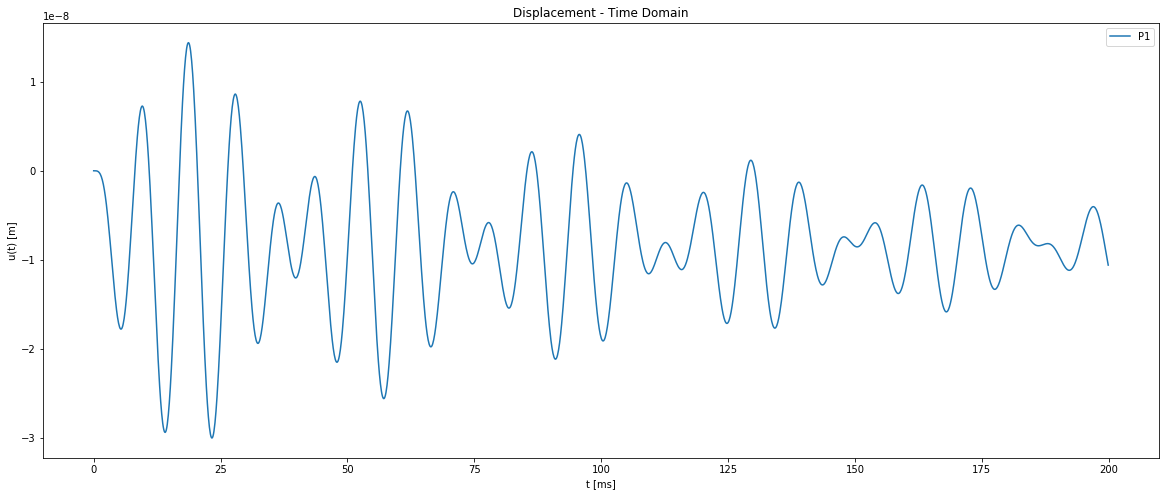

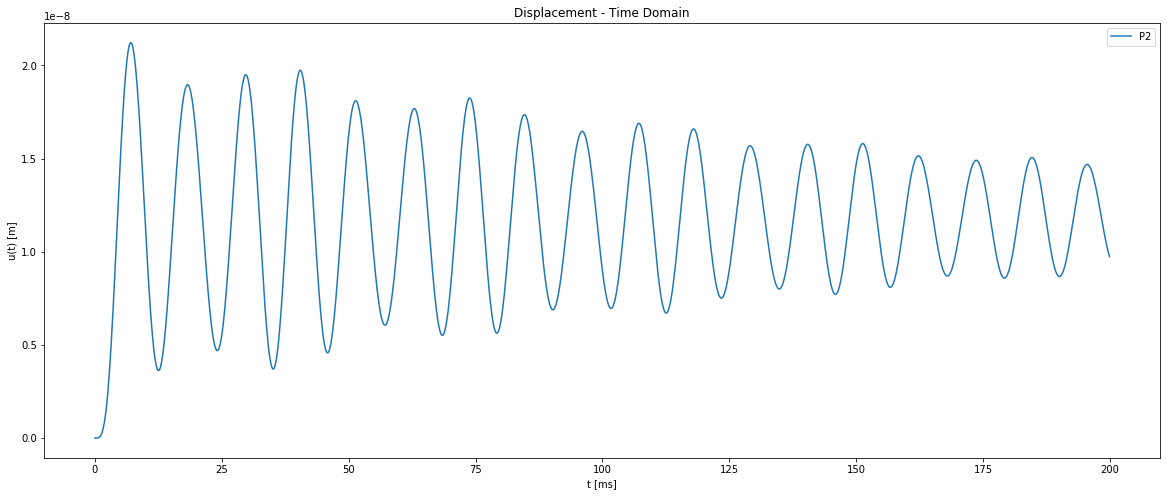

In [7]:
u_modal, uc_modal = full_excitation_analysis(tau=0.002, T=0.2, excitation_type='step',k=2)

f_max = 1/0.002 # Very crude estimation of max frequency.
dt = 1/(20*f_max) # Timestep 
time = np.arange(0, 0.2, dt)

#plot P1 & P2 for 2 modes
plot_P1_timedomain(u_modal, time, N1)
plot_P2_timedomain(u_modal, time, N2)

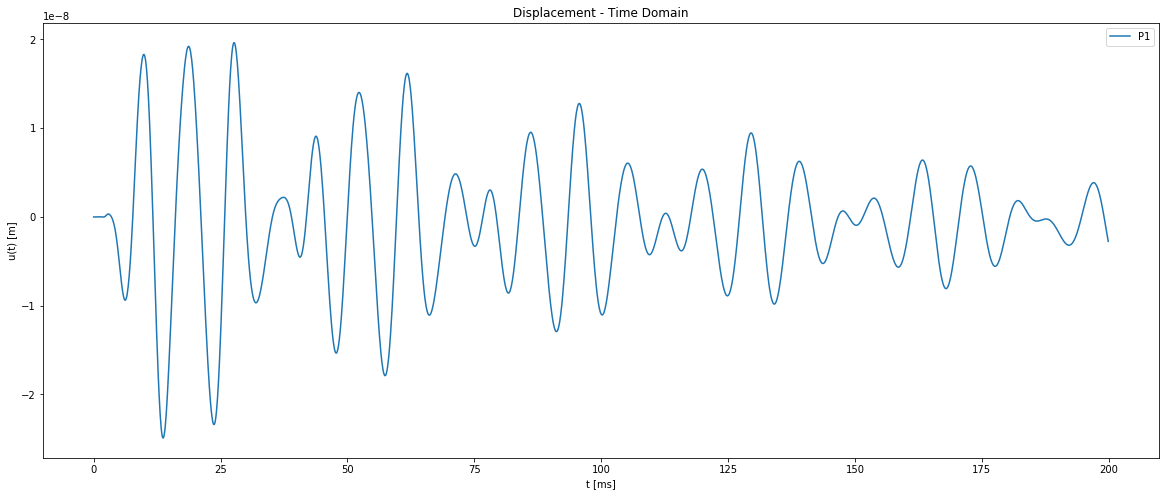

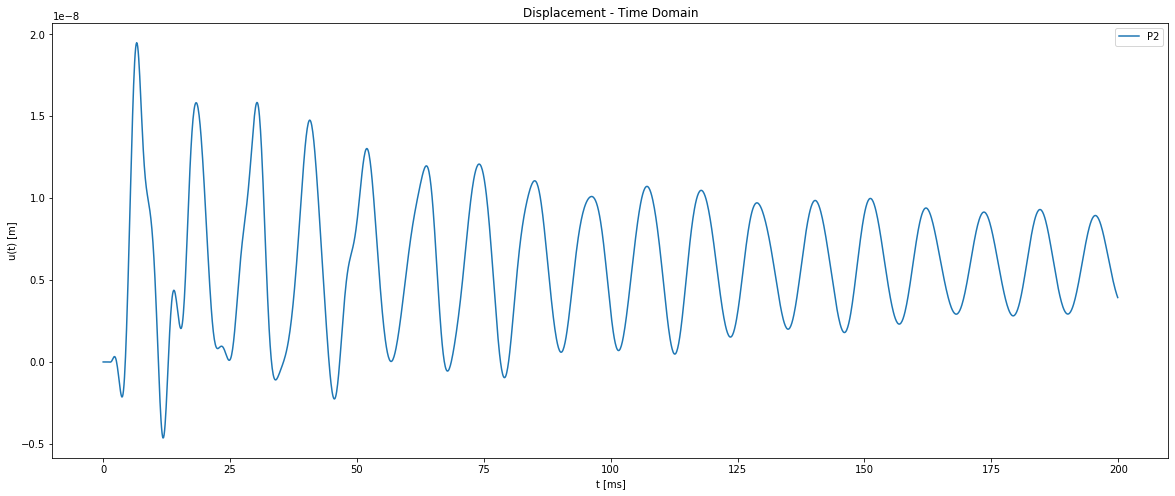

In [8]:
u_full, uc_full = full_excitation_analysis(tau=0.002, T=0.2, excitation_type='step')

#plot P1 & P2 for full system
plot_P1_timedomain(u_full, time, N1)
plot_P2_timedomain(u_full, time, N2)

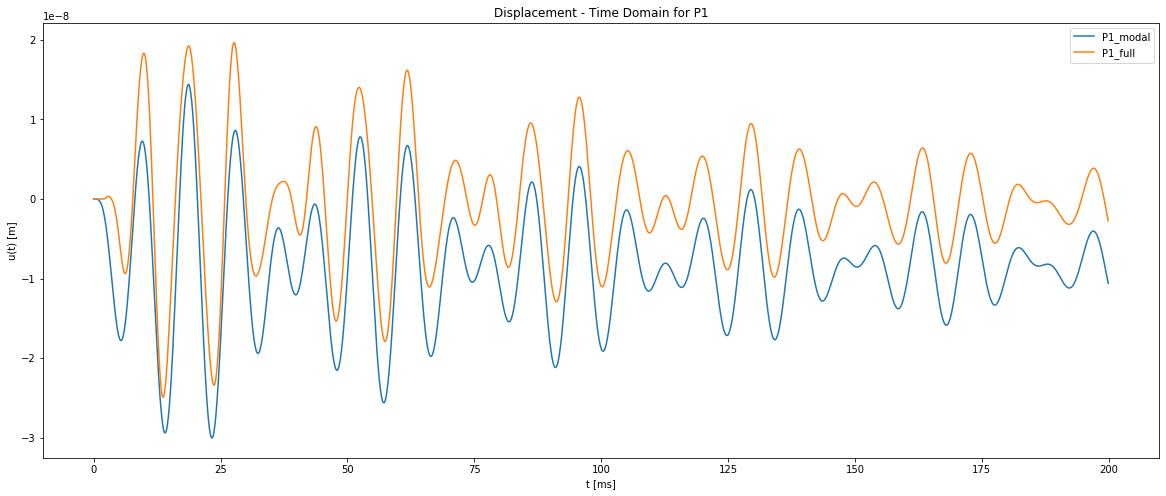

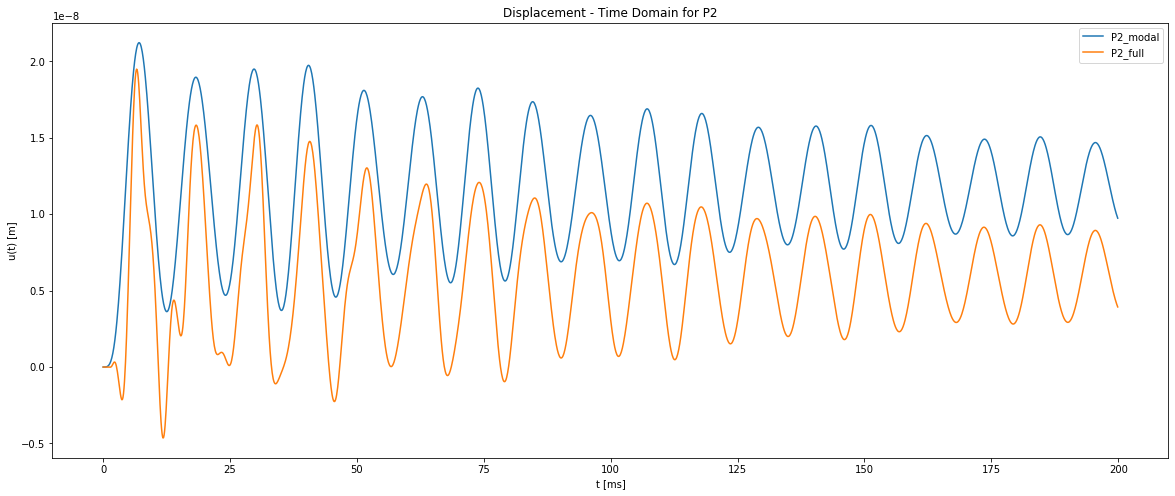

In [9]:
u_error_modal = u_full - u_modal

#Compare modalmodes with full system
compare_modalmodes(u_modal,u_full,time, N1, N2)

### Choice of Modes
* How does the error improve when you take more modes?
* Plot the response at selected nodes, e.g. N1, N2, center, for different models in the same graph.

In [10]:
u_mode3, uc_mode3 = full_excitation_analysis(tau=0.002, T=0.2, excitation_type='step', k=3)
u_mode4, uc_mode4 = full_excitation_analysis(tau=0.002, T=0.2, excitation_type='step', k=4)
u_mode5, uc_mode5 = full_excitation_analysis(tau=0.002, T=0.2, excitation_type='step', k=5)
u_mode6, uc_mode6 = full_excitation_analysis(tau=0.002, T=0.2, excitation_type='step', k=6)
u_mode7, uc_mode7 = full_excitation_analysis(tau=0.002, T=0.2, excitation_type='step', k=7)
u_mode8, uc_mode8 = full_excitation_analysis(tau=0.002, T=0.2, excitation_type='step', k=8)
u_mode9, uc_mode9 = full_excitation_analysis(tau=0.002, T=0.2, excitation_type='step', k=9)
u_mode10, uc_mode10 = full_excitation_analysis(tau=0.002, T=0.2, excitation_type='step', k=10)

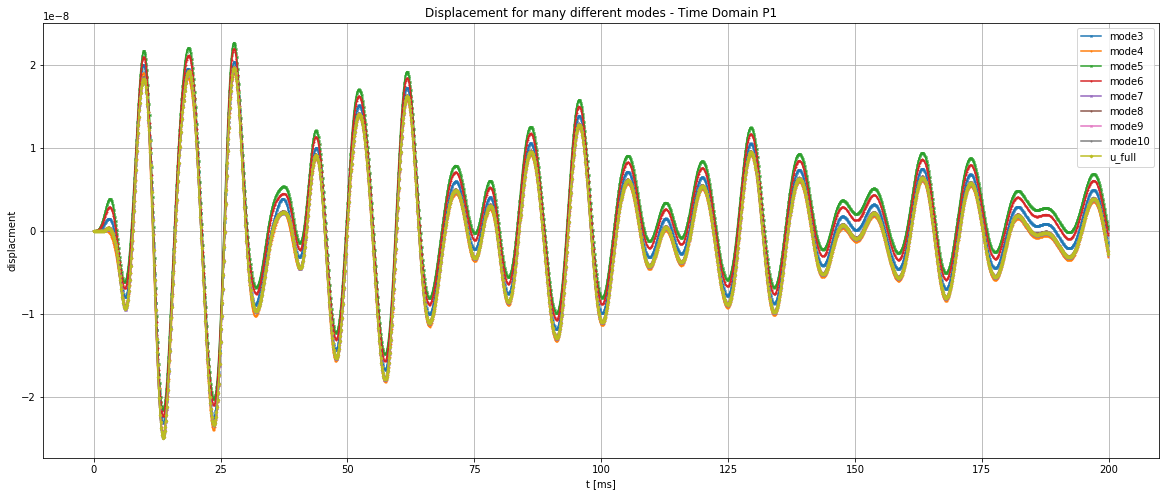

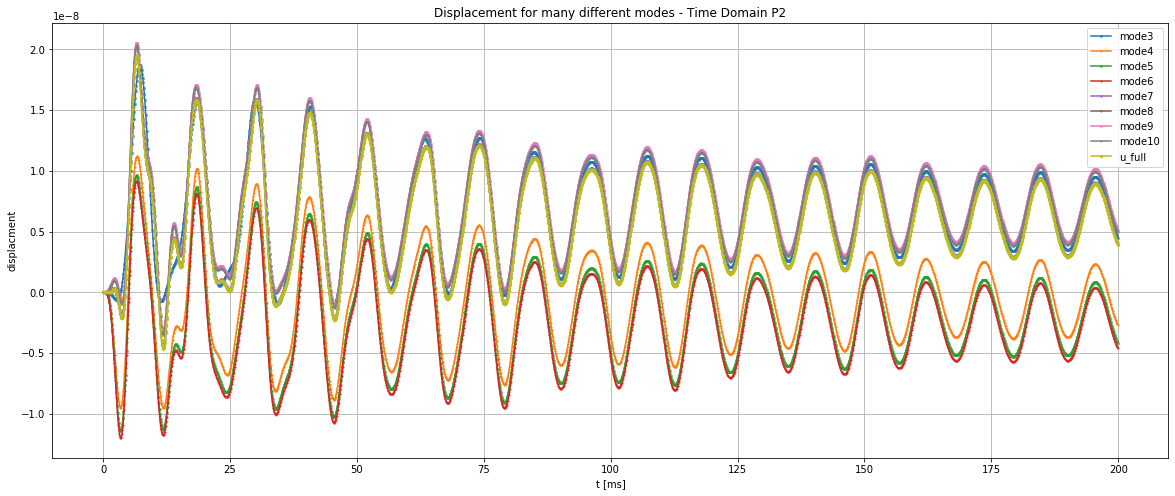

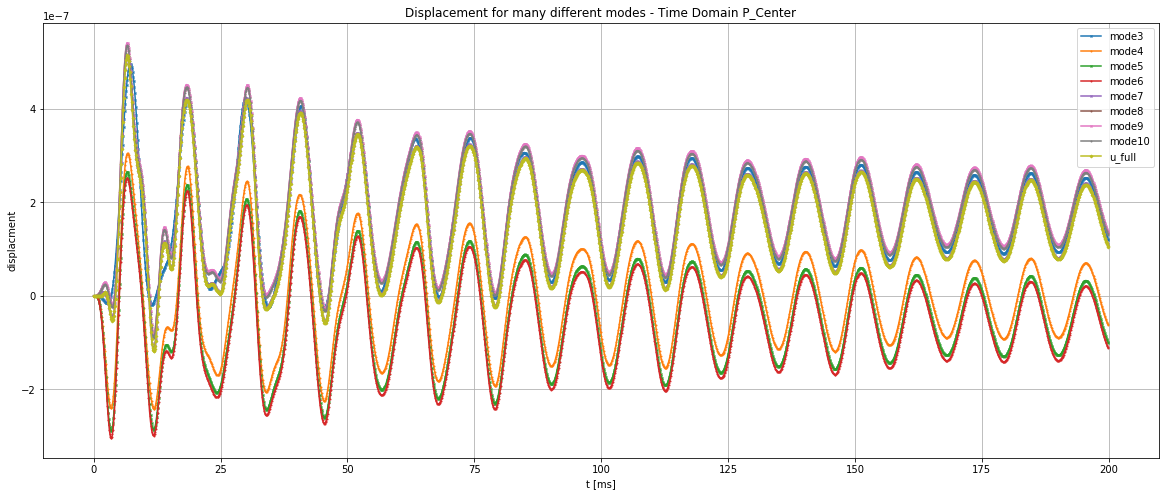

In [11]:
u_modes = np.array((u_mode3,u_mode4,u_mode5,u_mode6,u_mode7,u_mode8,u_mode9,u_mode10,u_full))
labels = ['mode3','mode4','mode5','mode6','mode7','mode8','mode9','mode10','u_full']
markers = ["x",".","x",".","x",".","x",".","D"]

fig, axP1 = plt.subplots(figsize=(20,8))
fig, axP2 = plt.subplots(figsize=(20,8))
fig, axP3 = plt.subplots(figsize=(20,8))

counter = 0
for i in u_modes:
    u = i
    axP1.plot(time*1000, i[N1],label = labels[counter], marker=markers[counter], markersize=2) # plotting t, a separately
    axP2.plot(time*1000, i[N2],label = labels[counter], marker=markers[counter], markersize=2)
    axP3.plot(time*1000, i[N_center],label = labels[counter], marker=markers[counter], markersize=2)
    counter = counter + 1

axP1.set_xlabel('t [ms]')
axP1.set_ylabel('displacment')
axP1.set_title(f"Displacement for many different modes - Time Domain P1")
axP1.grid(True)
axP1.legend()

axP2.set_xlabel('t [ms]')
axP2.set_ylabel('displacment')
axP2.set_title(f"Displacement for many different modes - Time Domain P2")
axP2.grid(True)
axP2.legend()

axP3.set_xlabel('t [ms]')
axP3.set_ylabel('displacment')
axP3.set_title(f"Displacement for many different modes - Time Domain P_Center")
axP3.grid(True)
axP3.legend()

plt.show()

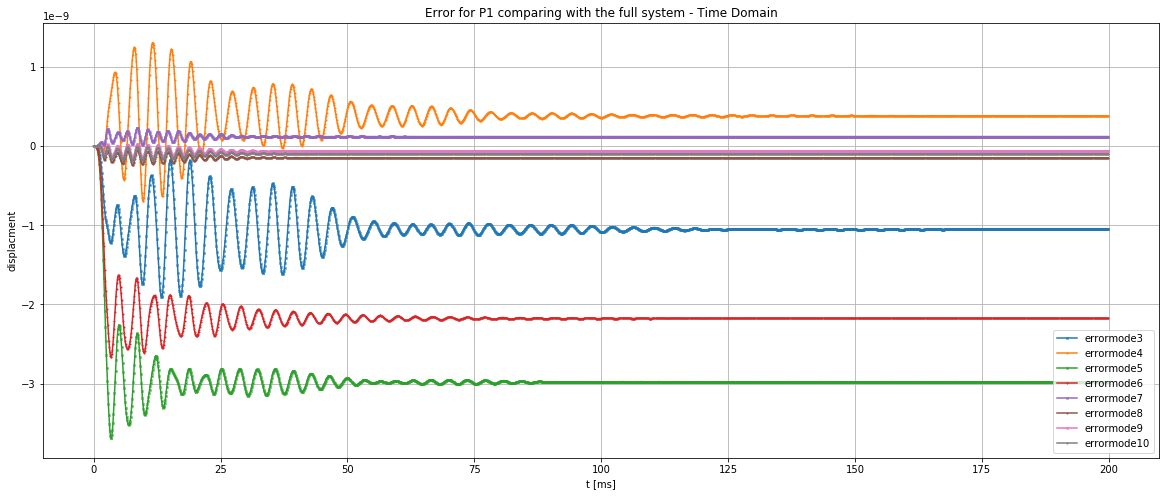

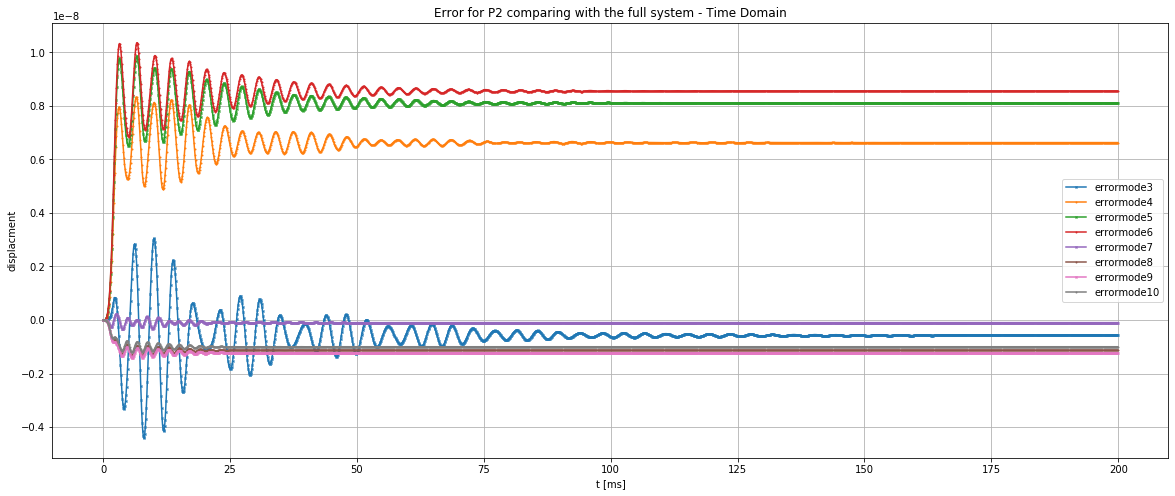

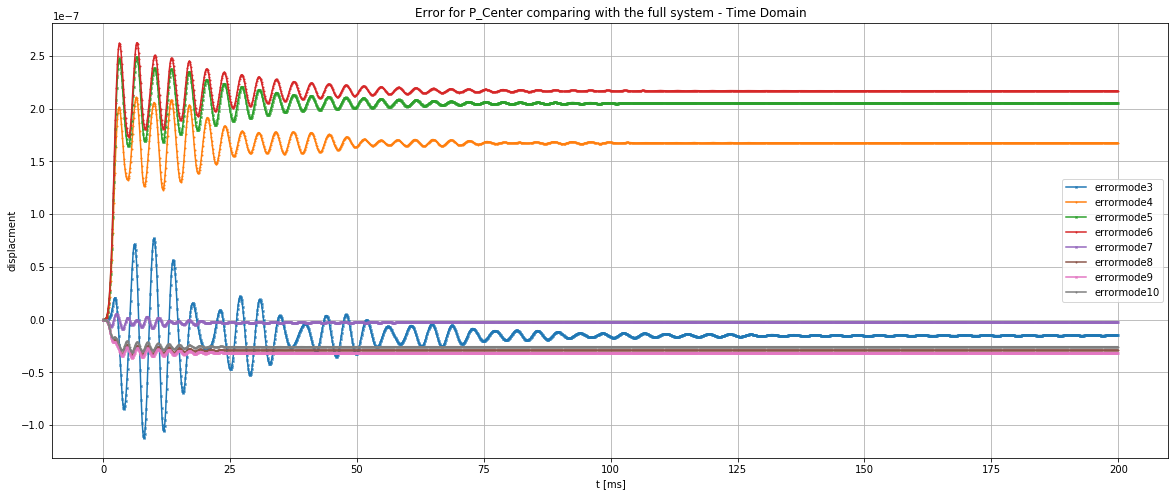

In [12]:
#Comparing error
u_error_mode3 = u_full - u_mode3
u_error_mode4 = u_full - u_mode4
u_error_mode5 = u_full - u_mode5
u_error_mode6 = u_full - u_mode6
u_error_mode7 = u_full - u_mode7
u_error_mode8 = u_full - u_mode8
u_error_mode9 = u_full - u_mode9
u_error_mode10 = u_full - u_mode10

u_error_modes = np.array((u_error_mode3,u_error_mode4,u_error_mode5,u_error_mode6,u_error_mode7,
                          u_error_mode8,u_error_mode9,u_error_mode10))
labels = ['errormode3','errormode4','errormode5','errormode6','errormode7','errormode8','errormode9','errormode10']
markers = ["x",".","x",".","x",".","x","."]

fig, axP1 = plt.subplots(figsize=(20,8))
fig, axP2 = plt.subplots(figsize=(20,8))
fig, axP3 = plt.subplots(figsize=(20,8))

counter = 0
for i in u_error_modes:
    u = i
    axP1.plot(time*1000, i[N1],label = labels[counter], marker=markers[counter], markersize=2) # plotting t, a separately
    axP2.plot(time*1000, i[N2],label = labels[counter], marker=markers[counter], markersize=2)
    axP3.plot(time*1000, i[N_center],label = labels[counter], marker=markers[counter], markersize=2)
    counter = counter + 1

axP1.set_xlabel('t [ms]')
axP1.set_ylabel('displacment')
axP1.set_title(f"Error for P1 comparing with the full system - Time Domain")
axP1.grid(True)
axP1.legend()

axP2.set_xlabel('t [ms]')
axP2.set_ylabel('displacment')
axP2.set_title(f"Error for P2 comparing with the full system - Time Domain")
axP2.grid(True)
axP2.legend()

axP3.set_xlabel('t [ms]')
axP3.set_ylabel('displacment')
axP3.set_title(f"Error for P_Center comparing with the full system - Time Domain")
axP3.grid(True)
axP3.legend()

plt.show()

### Time Evolution of Modal Corrdinates
* Visualize the time evolution of the used modal coordinates
* Do this for the results obtained with differnt modal bases
* Compute the modal contributions in the same way. Which modes contribute most for which model?

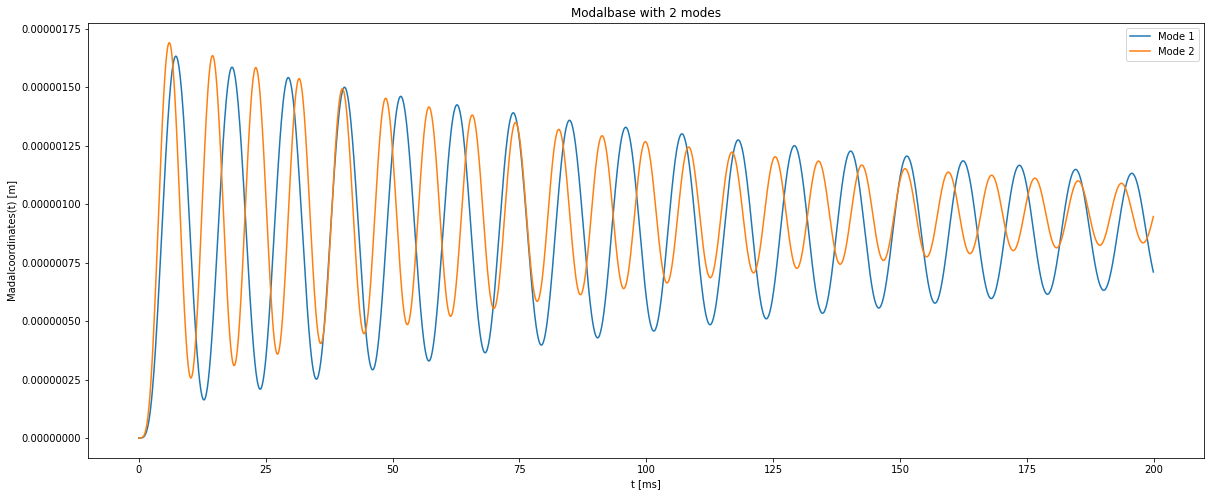

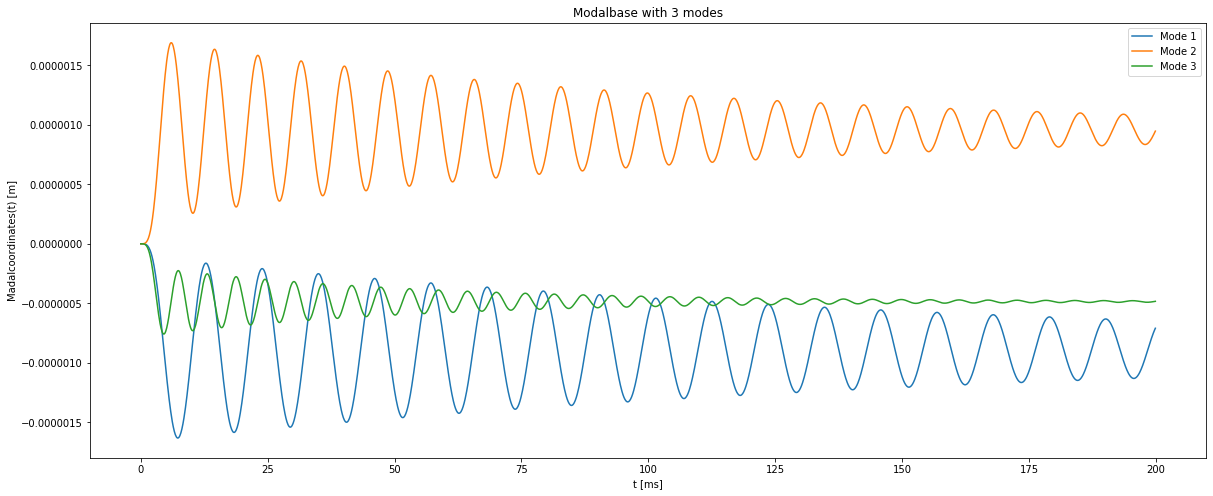

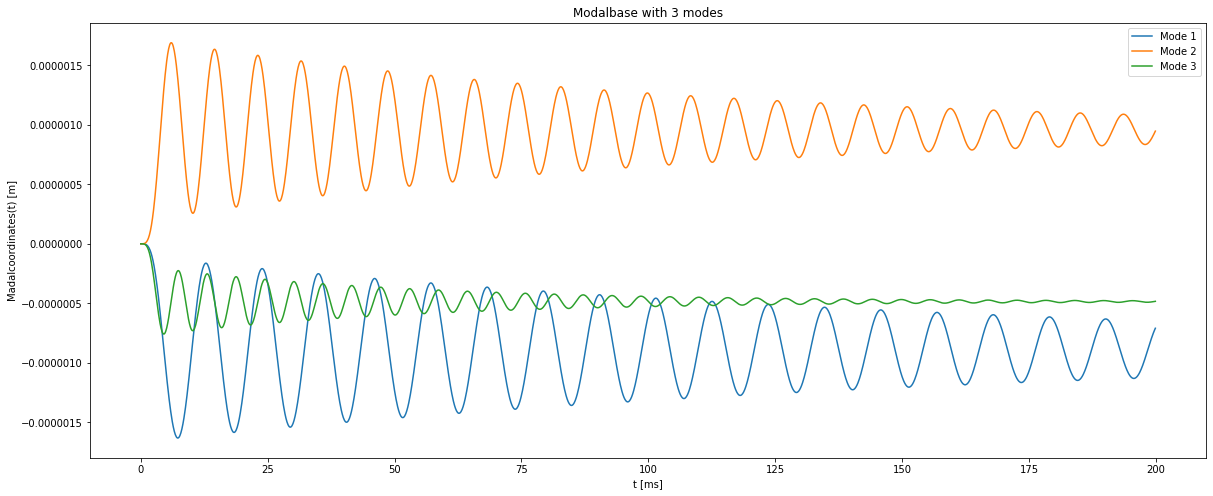

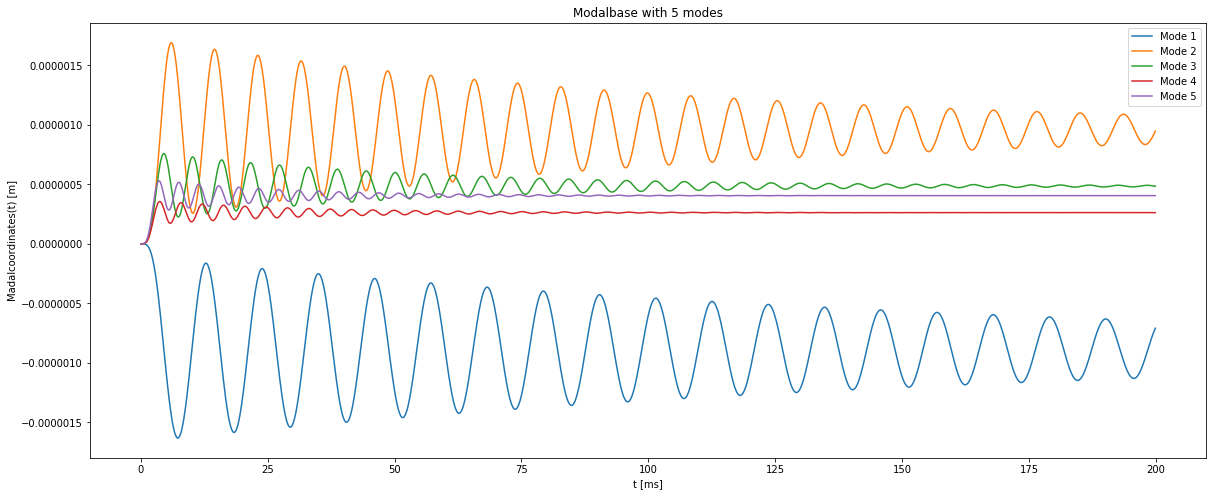

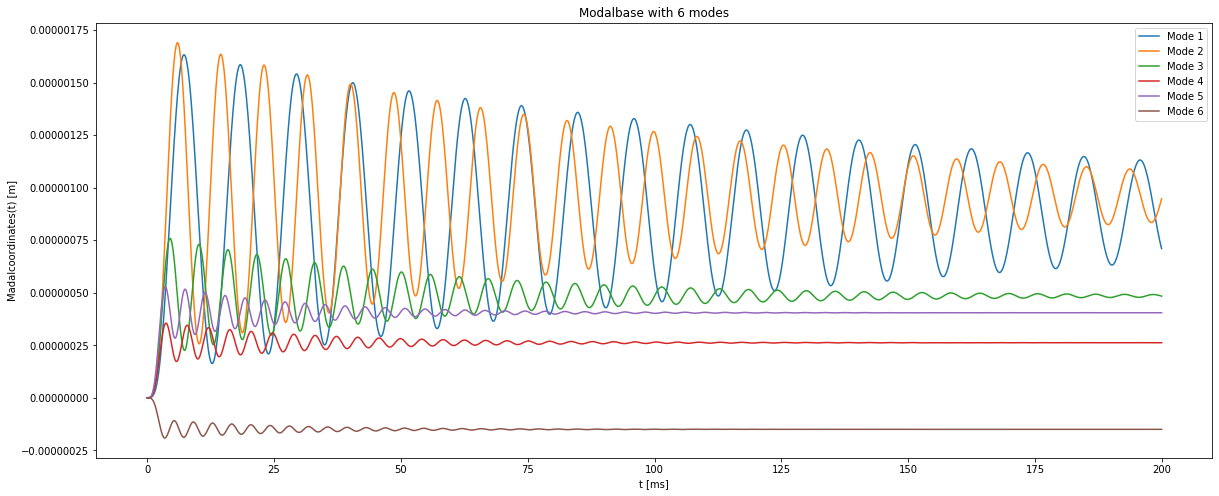

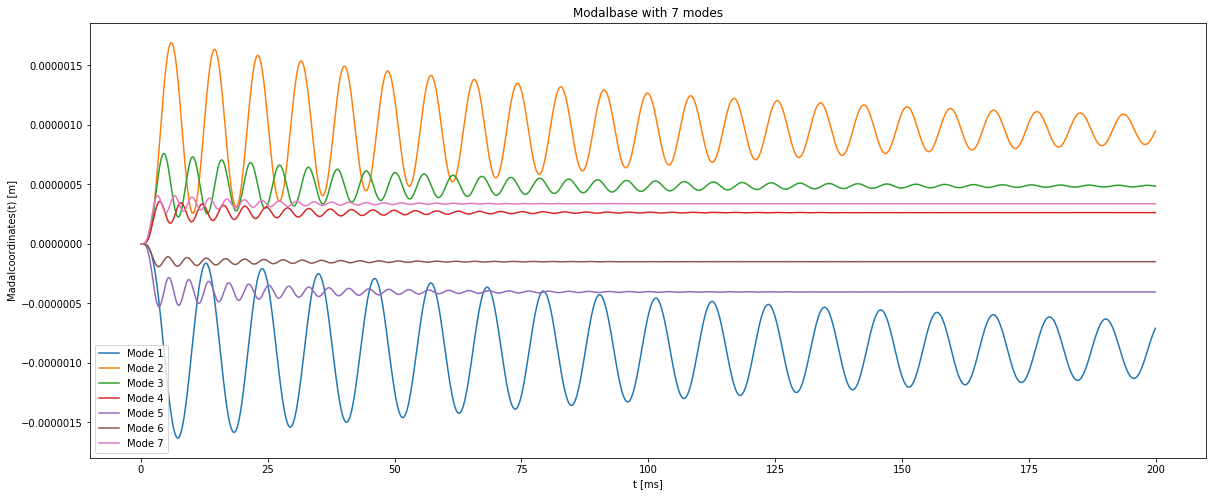

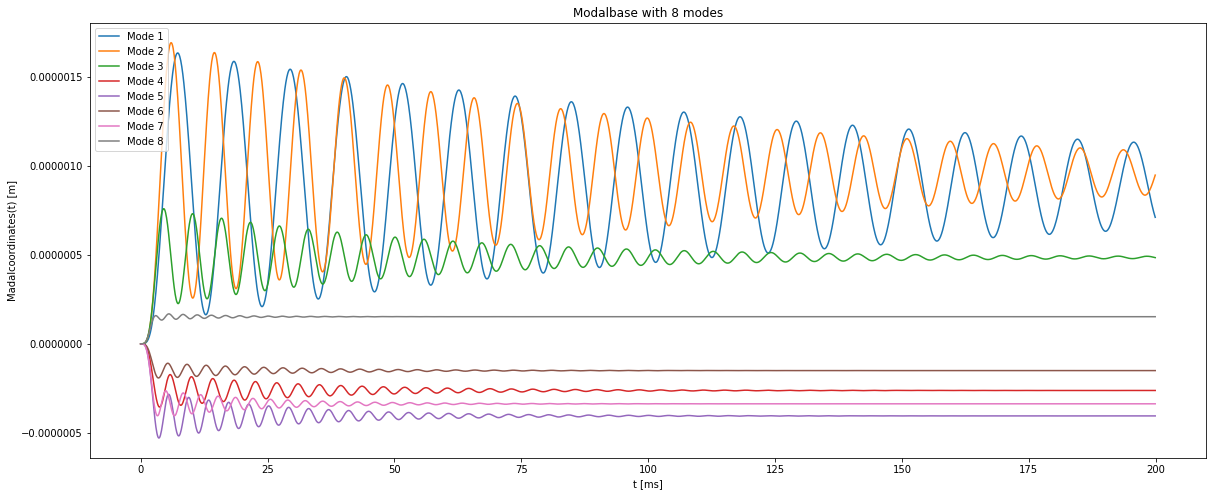

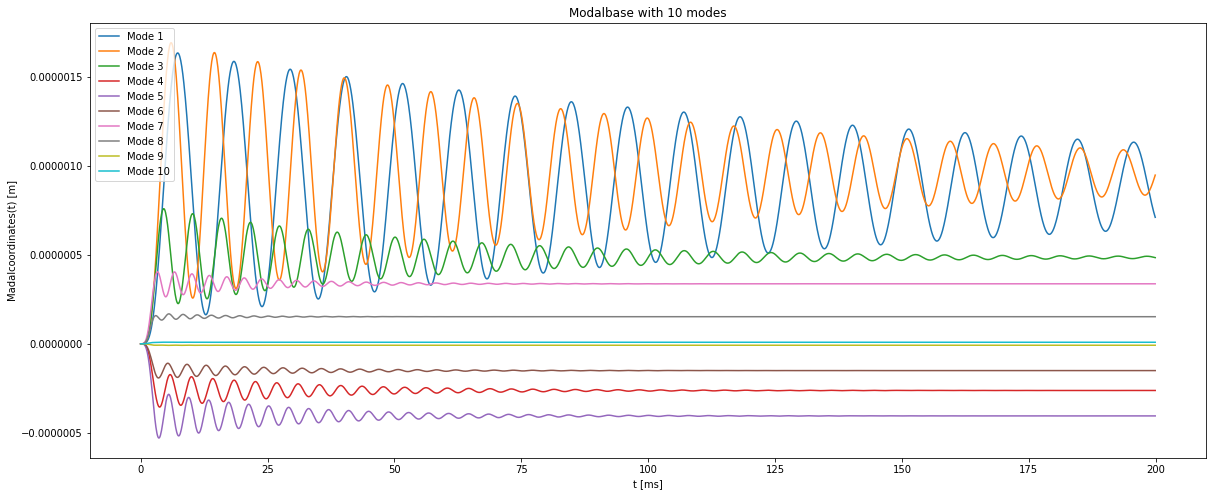

In [13]:
#Visualizing time evoultion of the modal cooridnates for different modal bsases
plot_modalcoordinates(uc_modal,time)
plot_modalcoordinates(uc_mode3,time)
plot_modalcoordinates(uc_mode3,time)
plot_modalcoordinates(uc_mode5,time)
plot_modalcoordinates(uc_mode6,time)
plot_modalcoordinates(uc_mode7,time)
plot_modalcoordinates(uc_mode8,time)
plot_modalcoordinates(uc_mode10,time)

In [14]:
#Define a function that computes rho for diffferent modal cooridnates
def plot_rho(uc): 
    rho = uc/np.linalg.norm(uc)
    Plot, Axis = plt.subplots(figsize=(20,8))
    for i in range(0,len(uc),1):
        Axis.plot(uc[i], rho[i] , label = "Rho%s" %(i+1))
    Axis.set_xlabel('Modes')
    Axis.set_ylabel('Rho')
    Axis.set_title(f"Rho for Modalbase with %s modes" %(len(uc)))
    Axis.legend()

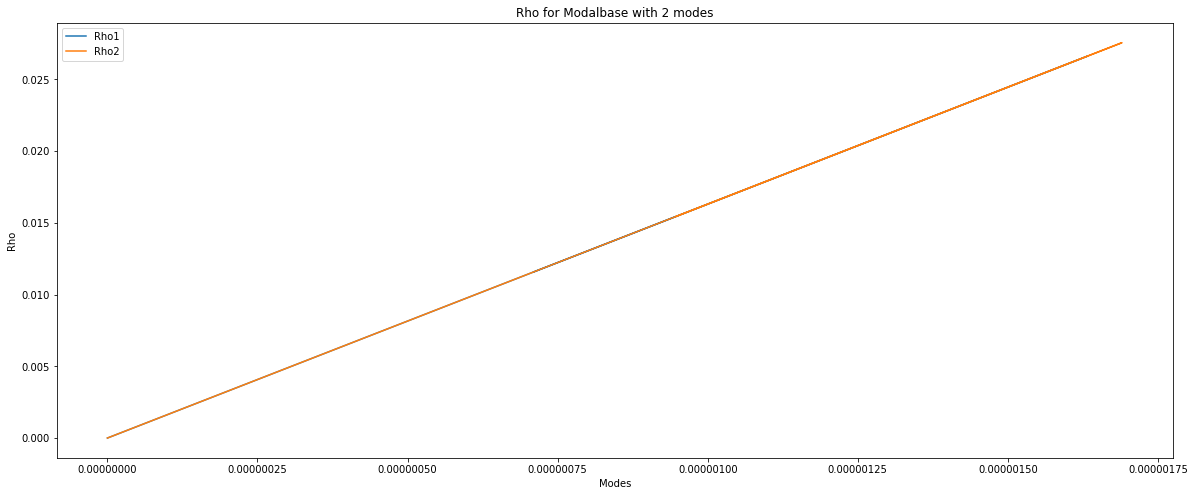

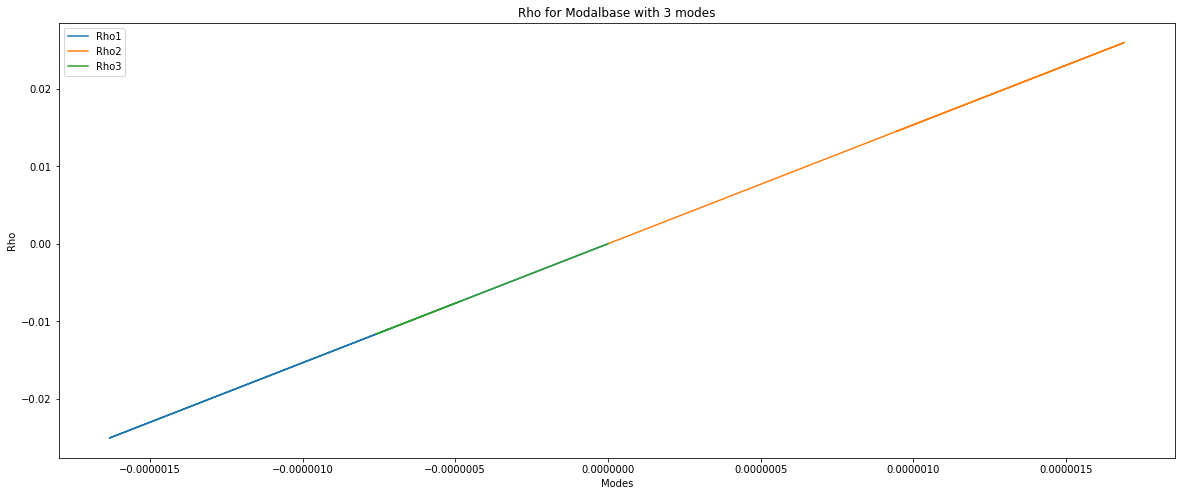

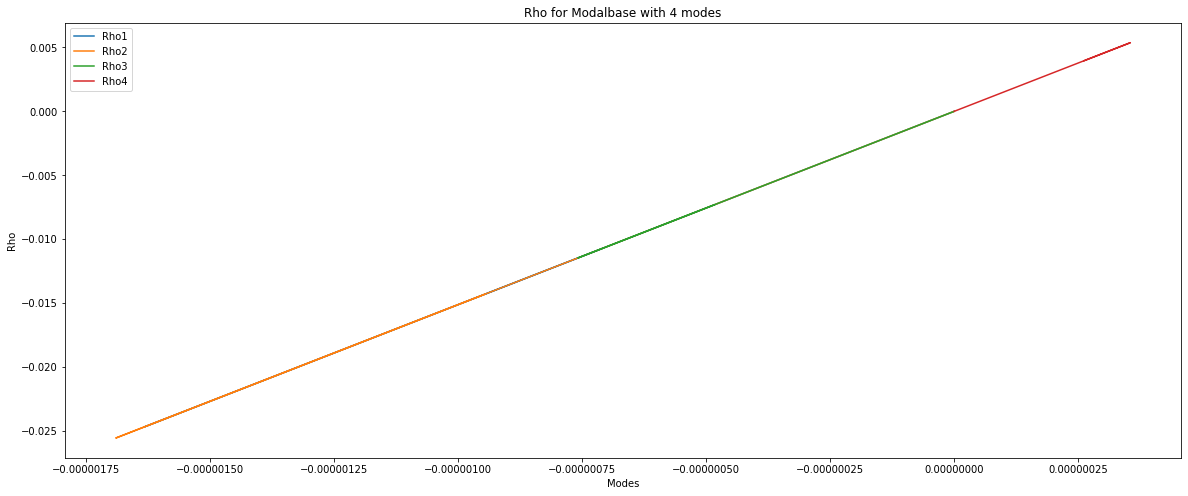

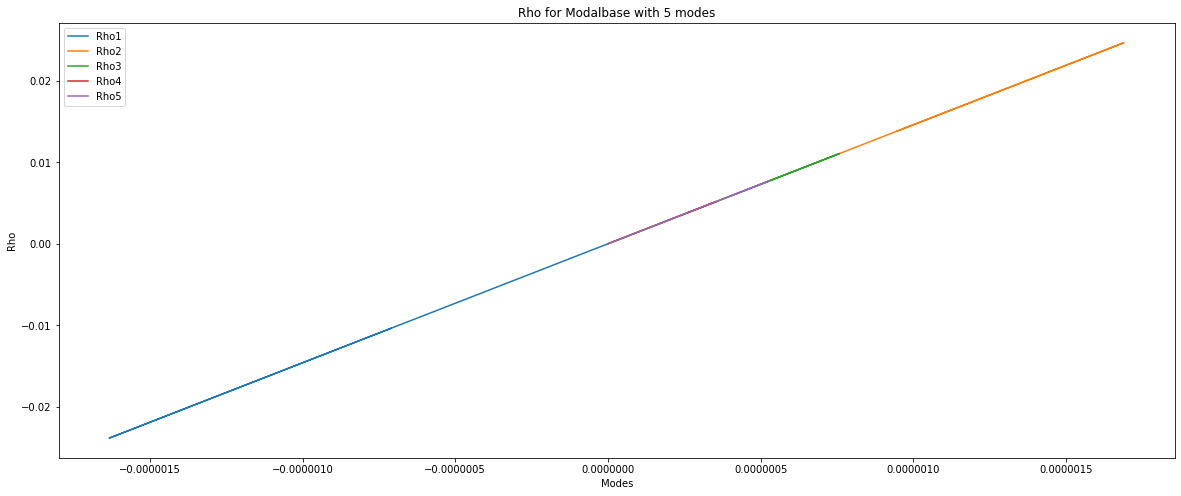

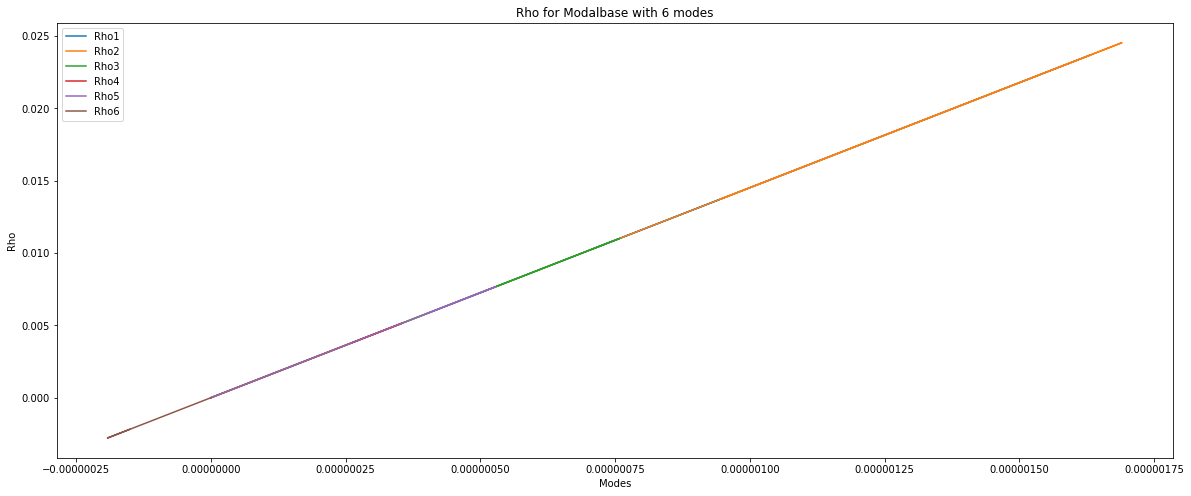

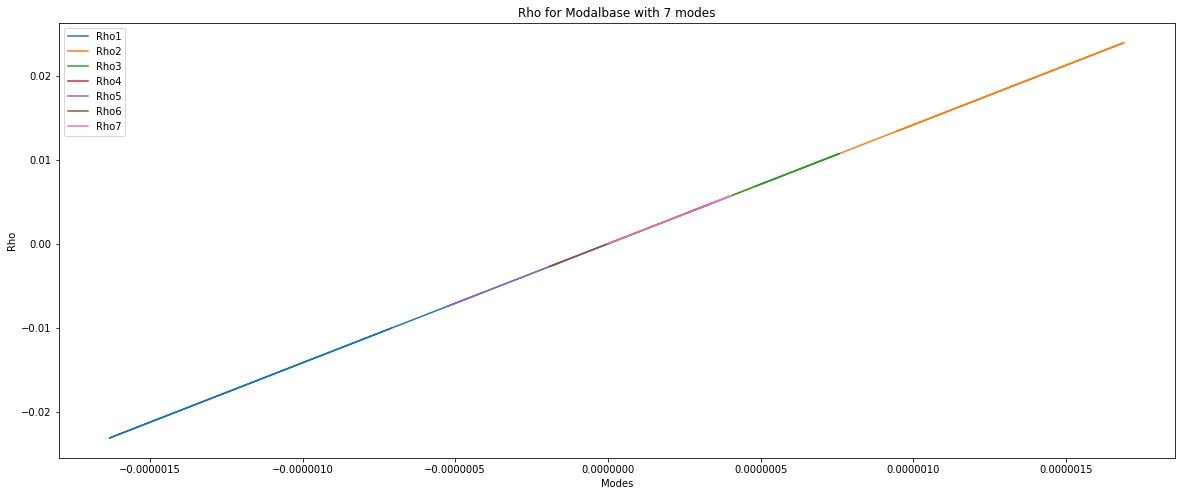

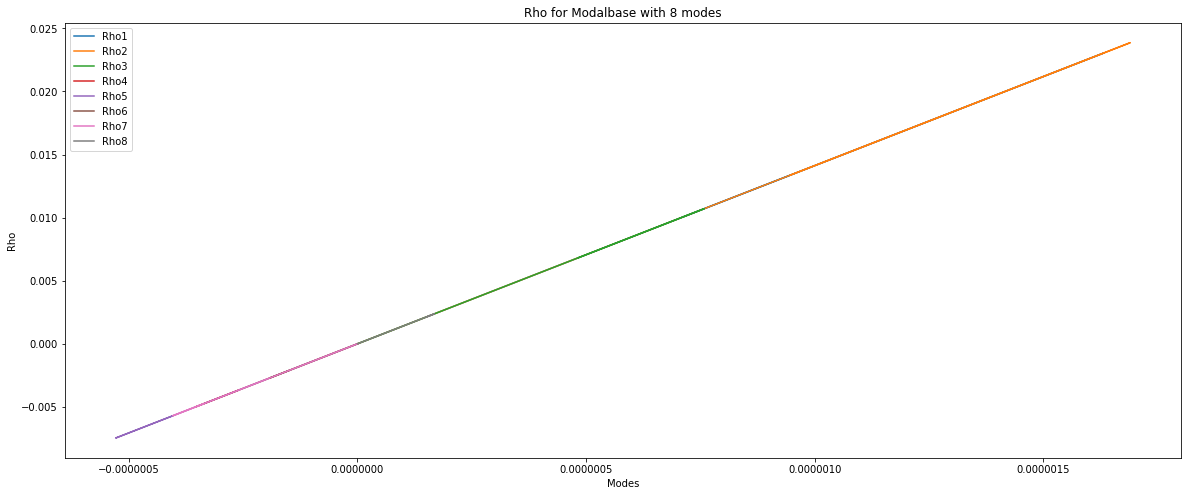

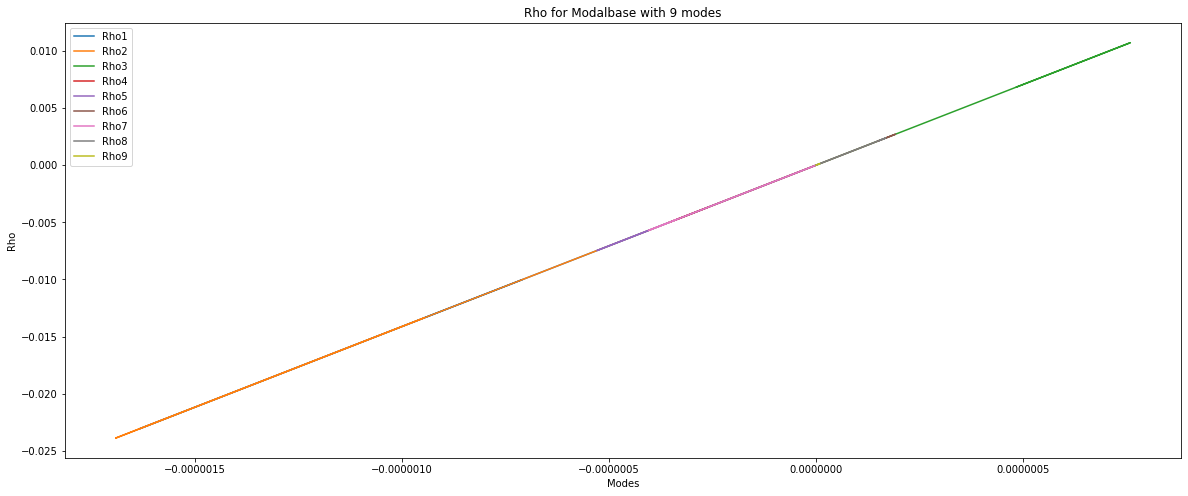

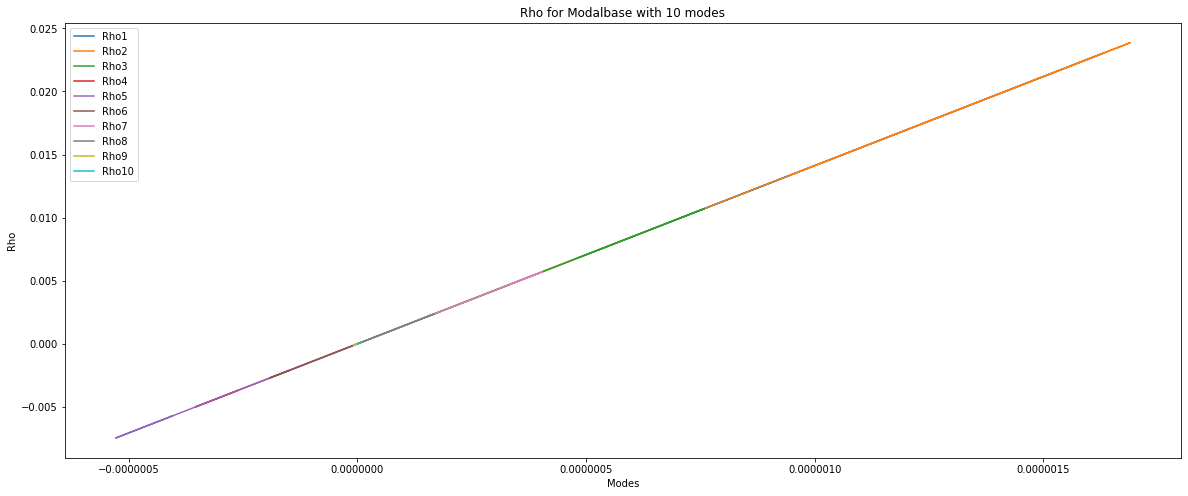

In [15]:
#Visualizing time evoultion of the modal cooridnates for different modal bsases
plot_rho(uc_modal)
plot_rho(uc_mode3)
plot_rho(uc_mode4)
plot_rho(uc_mode5)
plot_rho(uc_mode6)
plot_rho(uc_mode7)
plot_rho(uc_mode8)
plot_rho(uc_mode9)
plot_rho(uc_mode10)

# Steady State Oscillation | Frequency Domain

Now switch to frequency domain and compute the steady state response of the system.
For the sake of simplicity use a unit excitation at $P_1$.

## Task 2: Compute Harmonic Response using a Reduced Model

Use the first 10 modes to compute the steady state response for a unit forcing in z-direction at $P_1$.
Do the computation for Rayleigh damping and for Modal damping with a damping ratio of 0.01 for each mode.
Compare the results by plotting the transfer functions up to 300Hz.

### Compare damping models
* what is the difference between modal and Rayleigh damping?
* what happens if you only damp certain modes with modal damping?

### Modal contribution
* compute the modal contribution factors for each mode and plot them over the frequency
* When is which mode important?